<a href="https://colab.research.google.com/github/Tinddd28/labs-iadnmo-/blob/main/lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4 "Классификация изображений. Сверточные сети. Полносвязные сети с предобучением и дообучением"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm
import shutil

In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: fl

# 1. Подготовка данных
- создание нужных директорий;
- разделение на обучающую, тестовую и валидационные выбоки

In [4]:
flowers_directory = "flowers"

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

root = "dataset"
train_folder_name = "train"
validation_folder_name = "validation"
test_folder_name = "test"

In [5]:
os.mkdir(root)
os.mkdir(os.path.join(root, train_folder_name))
os.mkdir(os.path.join(root, validation_folder_name))
os.mkdir(os.path.join(root, test_folder_name))

for flower_folder in tqdm(os.listdir(flowers_directory)):
    os.mkdir(os.path.join(root, train_folder_name, flower_folder))
    os.mkdir(os.path.join(root, validation_folder_name, flower_folder))
    os.mkdir(os.path.join(root, test_folder_name, flower_folder))

    flower_images_path = os.listdir(os.path.join(flowers_directory, flower_folder))

    train_size = int(train_ratio * len(flower_images_path))
    validation_size = int(validation_ratio * len(flower_images_path))
    test_size = int(test_ratio * len(flower_images_path))

    for image_path in flower_images_path[:train_size]:
        shutil.copyfile(os.path.join(flowers_directory, flower_folder, image_path), os.path.join(root, train_folder_name, flower_folder, image_path))

    for image_path in flower_images_path[train_size:train_size + validation_size]:
        shutil.copyfile(os.path.join(flowers_directory, flower_folder, image_path), os.path.join(root, validation_folder_name, flower_folder, image_path))

    for image_path in flower_images_path[train_size + validation_size:]:
        shutil.copyfile(os.path.join(flowers_directory, flower_folder, image_path), os.path.join(root, test_folder_name, flower_folder, image_path))


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Проверка правильного разделения данных

In [6]:
for data in [train_folder_name, validation_folder_name, test_folder_name]:
    print(f"==== {data} ====")
    for flower_folder in os.listdir(os.path.join(root, data)):
        print(f"{flower_folder}: {len(os.listdir(os.path.join(root, data, flower_folder)))}")
    print()

==== train ====
dandelion: 631
sunflower: 439
daisy: 458
rose: 470
tulip: 590

==== validation ====
dandelion: 210
sunflower: 146
daisy: 152
rose: 156
tulip: 196

==== test ====
dandelion: 211
sunflower: 148
daisy: 154
rose: 158
tulip: 198



Заполнение выборок данных

Каждая из выборок имеет размер батча 64, размер изображения, загружаемый в выборку - 128х128

In [7]:
train = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, train_folder_name),
    batch_size=64,
    image_size=(128, 128),
)
validation = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, validation_folder_name),
    batch_size=64,
    image_size=(128, 128),
)
test = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, test_folder_name),
    batch_size=64,
    image_size=(128, 128),
)

Found 2588 files belonging to 5 classes.
Found 860 files belonging to 5 classes.
Found 869 files belonging to 5 classes.


# 2. Работа с нейронными сетями

## Создание сверточной нейронной сети (CNN)

Моедль содержит сверточные нейронные слои: Conv2D, MaxPooling2D

- `Conv2D`: Преобразует входное изображение в новый набор признаков, которые выделяют важные паттерны (например, края, текстуры, углы)

- `MaxPooling2D`: Уменьшает размер этих признаков, сохраняя самые важные, что делает вычисления более эффективными и снижает риск переобучения.


Параметры для слоя Conv2D:
- `strides`: шаг перемещения пикселя, если > 1, то размер выходного тензера уменьшается;
- `padding`: определяет, как будут обрабатываться границы изображения:
  - `valid`: выходное изображение не уменьшается, т.к. фильтр не выходит за границы;
  - `same`: границы заполняются нулями, так чтобы выходное изображение сохраняло размеры;
- `kernel_size`: размер фильтра ((3, 3), (5, 5)).

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),

    # Аугментация данных
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", strides=(1, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", strides=(1, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", strides=(1, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax"),
])

In [18]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_6 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_6 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 62, 62, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688,037 (2.62 MB)

 Trainable params: 688,037 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="models/best_model_conv.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    ),
]

In [23]:
history = model.fit(
    train,
    epochs=1000,
    validation_data=validation,
    callbacks=callbacks,
)

Epoch 1/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.2681 - loss: 1.5359 - val_accuracy: 0.4837 - val_loss: 1.2149
Epoch 2/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5046 - loss: 1.1930 - val_accuracy: 0.4953 - val_loss: 1.2017
Epoch 3/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5753 - loss: 1.0666 - val_accuracy: 0.5233 - val_loss: 1.2003
Epoch 4/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5812 - loss: 1.0505 - val_accuracy: 0.5953 - val_loss: 1.0753
Epoch 5/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6230 - loss: 0.9558 - val_accuracy: 0.5802 - val_loss: 1.1095
Epoch 6/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6295 - loss: 0.9460 - val_accuracy: 0.6267 - val_loss: 0.9568
Epoch 7/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6688 - loss: 0.8520 - val_accuracy: 0.6570 - val_loss: 0.9391
Epoch 8/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6765 - loss: 0.8428 - val_accuracy: 0.

In [24]:
best_model_conv = tf.keras.models.load_model("models/best_model_conv.keras")

In [25]:
loss, accuracy = best_model_conv.evaluate(test)
print(f"Loss: {loss:.3f}")
print(f"Accuracy: {accuracy:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.7381 - loss: 0.8169
Loss: 0.811
Accuracy: 0.733


Фунция построения графиков значений Loss и Accuracy

In [8]:
def plot(history):
    epochs = len(history.history['loss'])
    epochs_range = range(epochs)

    loss = history.history['loss']
    val_loss = history.history['val_loss']


    plt.cla()
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    if 'accuracy' not in history.history.keys():
        return

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.cla()
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

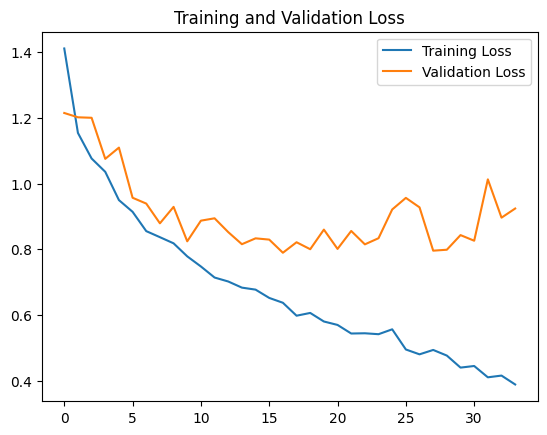

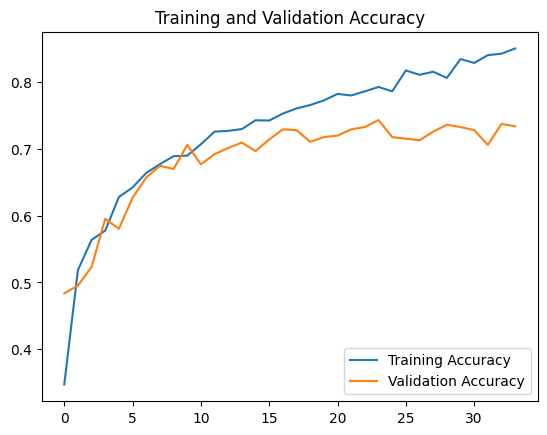

In [27]:
plot(history)

Построение графиков завимости значений Loss и Accuracy от количества эпох для обучающей и валидационных выборок

На графиках можно заметить, что значения Loss/Accuracy соответственно убывают/возрастают для обучающей выборки с течением эпох, потому что происходит обновление весов постоянно, на валидационной же выборке, в определнный момент значения Loss/Accuracy перестают убывать/расти.

## Автокодировщик

In [44]:
train_encode = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, train_folder_name),
    batch_size=64,
    image_size=(64, 64),
)

validation_encode = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, validation_folder_name),
    batch_size=64,
    image_size=(64, 64),
)

train_autoencoder = train_encode.map(lambda x, y: (x / 255.0, x / 255.0))
validation_autoencoder = validation_encode.map(lambda x, y: (x / 255.0, x / 255.0))

Found 2588 files belonging to 5 classes.
Found 860 files belonging to 5 classes.


In [45]:
convencoder = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="selu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="selu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="selu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

])

convdecoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="selu"),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="selu"),
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="selu"),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="sigmoid")
])


convautoencoder = tf.keras.models.Sequential([convencoder, convdecoder])
convautoencoder.build(input_shape=(None, 64, 64, 3))


In [46]:
convautoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['rounded_accuracy'],
)

In [47]:
convautoencoder.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 8, 8, 64)          23584     
                                                                 
 sequential_33 (Sequential)  (None, 64, 64, 3)         60451     
                                                                 
Total params: 84035 (328.26 KB)
Trainable params: 84035 (328.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
callbacks = [
    # Остановка обучения, если качество на валидации перестало улучшаться
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode="max",
        patience=10
    ),

    # Сохранение лучшей модели по результатам на валидации
    tf.keras.callbacks.ModelCheckpoint(
        'models/best_autoencoder.keras',
        monitor='val_loss',
        save_best_only=True
    ),
]

In [53]:
history_autoencoder = convautoencoder.fit(
    train_autoencoder,
    epochs=100,
    validation_data=validation_autoencoder,
    callbacks=callbacks
)

Epoch 1/100
41/41 [==============================] - 22s 519ms/step - loss: 0.4967 - accuracy: 0.7837 - val_loss: 0.4930 - val_accuracy: 0.7822
Epoch 2/100
41/41 [==============================] - 23s 549ms/step - loss: 0.4967 - accuracy: 0.7837 - val_loss: 0.4929 - val_accuracy: 0.7825
Epoch 3/100
41/41 [==============================] - 23s 529ms/step - loss: 0.4967 - accuracy: 0.7833 - val_loss: 0.4927 - val_accuracy: 0.7819
Epoch 4/100
41/41 [==============================] - 23s 543ms/step - loss: 0.4967 - accuracy: 0.7840 - val_loss: 0.4930 - val_accuracy: 0.7803
Epoch 5/100
41/41 [==============================] - 22s 533ms/step - loss: 0.4969 - accuracy: 0.7831 - val_loss: 0.4925 - val_accuracy: 0.7852
Epoch 6/100
41/41 [==============================] - 23s 538ms/step - loss: 0.4964 - accuracy: 0.7850 - val_loss: 0.4928 - val_accuracy: 0.7825
Epoch 7/100
41/41 [==============================] - 24s 556ms/step - loss: 0.4964 - accuracy: 0.7848 - val_loss: 0.4926 - val_accuracy:

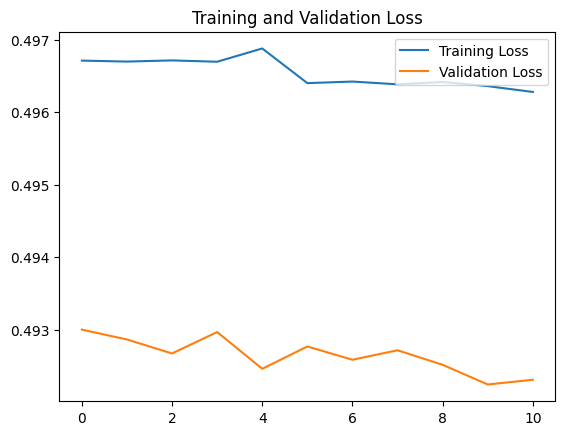

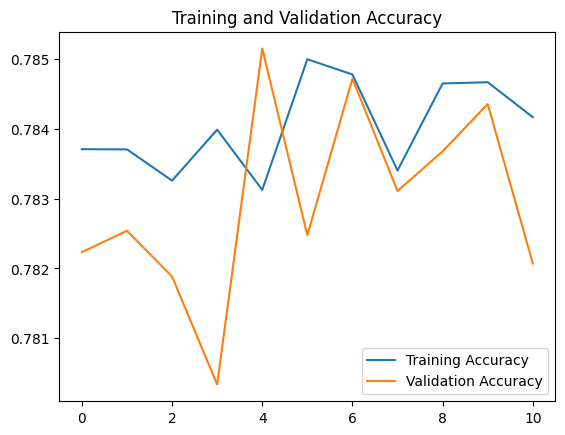

In [54]:
plot(history_autoencoder)

In [56]:
best_autoencoder = tf.keras.models.load_model("models/best_autoencoder.keras")

input = tf.keras.layers.Input(shape=(64, 64, 3))

x = input
for layer in best_autoencoder.layers[:-1]:
  x = layer(x)

encoder = tf.keras.models.Model(inputs=input, outputs=x)

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential_32 (Sequential)  (None, 8, 8, 64)          23584     
                                                                 
Total params: 23584 (92.12 KB)
Trainable params: 23584 (92.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [67]:
train_fcnn = train_datagen.flow_from_directory(
    directory=os.path.join(root, train_folder_name),
    batch_size=64,
    target_size=(64, 64),
    class_mode="categorical",
)

val_fcnn = val_datagen.flow_from_directory(
    directory=os.path.join(root, validation_folder_name),
    batch_size=64,
    target_size=(64, 64),
    class_mode="categorical",
)

test_fcnn = val_datagen.flow_from_directory(
    directory=os.path.join(root, test_folder_name),
    batch_size=64,
    target_size=(64, 64),
    class_mode="categorical",
)

Found 2588 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Found 869 images belonging to 5 classes.


In [68]:
for layer in encoder.layers:
  layer.trainable = False

In [84]:
modelFCNN = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="softmax"),
])

modelFCNN.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)



In [85]:
modelFCNN.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 64)          23584     
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_30 (Dense)            (None, 64)                262208    
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 16)              

In [73]:
callbacks = [
    # Остановка обучения, если качество на валидации перестало улучшаться
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=20),
    # Сохранение лучшей модели по результатам на валидации
    tf.keras.callbacks.ModelCheckpoint(
        filepath="models/best_model_FCNN.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    ),
]

In [ ]:
modelFCNN_history = modelFCNN.fit(
    train_fcnn,
    epochs=100,
    validation_data=val_fcnn,
    callbacks=callbacks
)

Epoch 1/100
41/41 [==============================] - 9s 211ms/step - loss: 1.0804 - accuracy: 0.5549 - val_loss: 1.0310 - val_accuracy: 0.5651
Epoch 2/100
41/41 [==============================] - 9s 208ms/step - loss: 1.0947 - accuracy: 0.5653 - val_loss: 1.0085 - val_accuracy: 0.6023
Epoch 3/100
41/41 [==============================] - 8s 205ms/step - loss: 1.0602 - accuracy: 0.5692 - val_loss: 1.0173 - val_accuracy: 0.5988
Epoch 4/100
41/41 [==============================] - 8s 207ms/step - loss: 1.0902 - accuracy: 0.5641 - val_loss: 0.9654 - val_accuracy: 0.6105
Epoch 5/100
41/41 [==============================] - 9s 214ms/step - loss: 1.0542 - accuracy: 0.5668 - val_loss: 1.0257 - val_accuracy: 0.6035
Epoch 6/100
41/41 [==============================] - 8s 202ms/step - loss: 1.0714 - accuracy: 0.5618 - val_loss: 1.0120 - val_accuracy: 0.6012
Epoch 7/100
41/41 [==============================] - 8s 208ms/step - loss: 1.0623 - accuracy: 0.5630 - val_loss: 0.9903 - val_accuracy: 0.6140

In [ ]:
plot(modelFCNN_history)